# Implementing ANN using Tensorflow - Final Project
## Using a Convolutional Neural Network for genre Classification in music
---

by Group 03 - Lea Doppertin and Sven Groen

We are trying to recreate the results achieved by:

http://cs229.stanford.edu/proj2018/report/21.pdf

---

# Introduction

## Importing Librarys

In [1]:
import tensorflow as tf
import pandas as pd
import os
import numpy as np
import librosa as lb
import matplotlib.pyplot as plt
import IPython.display as ipd
import random

# The Dataset

The GTZAN dataset was also used by Huang, Serafini and Pugh [1]. It consists of 1000 wav-audio files with each 30 secounds of length. They are sorted by musical genre. In [1] the Authors did some preprocessing to the audio in order to achieve better results:

>"From each clip, we sampled a
contiguous 2-second window at four random locations, thus augmenting our data to 8000 clips of two seconds each.
Since this data was sampled at 22050HZ, this leaves us with 44100 features for the raw audio input. We restricted
our windows to two seconds to limit the number of features. We found that 44100 features was the perfect balance
between length of audio sample and dimension of feature space. Thus after pre-processing our input is of shape (8000,
CS229 Final Report - Music Genre Classification
44100), where each feature denotes the amplitude at a certain timestep out of the 44100. We also used 100 samples of
un-augmented data each of our cross validation and test sets."

## Loading the Data in Python

### creating a csv for easier use

Having the data in a Pandas Dataframe format makes it easier to access the files.

In [2]:
genre_directory = os.getcwd() + "\data\genres"

#get the labels (all Genres)
for dirpath, dirname, filename in os.walk(genre_directory):
    labels = dirname
    break

# creating touple dataset
data = []
for genre in labels:
    path = genre_directory + "\\" + genre
    for dirpath, dirnames, filenames in os.walk(path):
        for file in filenames:
            data.append((file,"data/genres/"+genre+"/"+file , genre))
            
#"data/genres/" + genre

In [4]:
df = pd.DataFrame(data, columns = ["filename","path","genre"])
df.head()


,filename,path,genre
0,blues.00000.wav,data/genres/blues/blues.00000.wav,blues
1,blues.00001.wav,data/genres/blues/blues.00001.wav,blues
2,blues.00002.wav,data/genres/blues/blues.00002.wav,blues
3,blues.00003.wav,data/genres/blues/blues.00003.wav,blues
4,blues.00004.wav,data/genres/blues/blues.00004.wav,blues


In [5]:
print("Our Dataset consists of {} files.".format(len(df)))

Our Dataset consists of 1000 files.


### Loading the Data

In [6]:
signals = []
for file in df["path"]:
    signal,sampling_rate= lb.load(file)
    signals.append(signal)

In [7]:
# Lets hear a random example
ipd.Audio(np.random.choice(signals),rate=sampling_rate)

#### Preprocessing (not sure if necessary)

##### 2-second random samples

We need to sample contiguous 2-second window at four random locations.
To get the duration of each signal in seconds we need to divide it by the sampling rate:

$\frac{len(signal)}{sampling\_rate} = duration_{secounds}$

$\Leftrightarrow len(signal) = duration_{secounds} * sampling\_rate$


In [8]:
len_signal = 2 * sampling_rate
print("To receive 2 second random clips from our audio signal, we have to look at {} continous entries in our numpy signal.".format(len_signal))

To receive 2 second random clips from our audio signal, we have to look at 44100 continous entries in our numpy signal.


To achieve this we pick one random starting index (and make sure it can maximialy be at 28 seconds) and return the signal from that point on for 2 seconds:

In [9]:
# get a random starting point in the 30 sec. clip
def get_rand_sample(signal,duration,sr=22050):
    len_signal=duration * sr
    rand_index = np.random.randint(len(signal)-len_signal+1,size=1)[0]
    
    return signal[rand_index: rand_index+len_signal]

# play a random 2 sec. clip from a random sample
example = get_rand_sample(signals[np.random.randint(len(signals))],2,sr=sampling_rate)
assert(len(example)/sampling_rate==2.0)
ipd.Audio(example, rate=sampling_rate)

now we need 4 of these 2 second samples for each file.

In [10]:
from collections import defaultdict
data = defaultdict(list)

for i,file in enumerate(df["path"]):
    signal,sr = lb.load(file)
    [data[df.iloc[i]["genre"]].append(get_rand_sample(signal=signal,duration=2,sr=sr)) for _ in range(4)] #get 4 samples
    

In [11]:
i=0
for genre in data:
    for entry in data[genre]:
        i+=1
assert i == len(df)*4

### Mel-Spectograms

The original authors converted the raw audio signal into mel-spectograms.
To get the mel-spectogram we use librosas [melspectrogram()](https://librosa.github.io/librosa/generated/librosa.feature.melspectrogram.html) method

When it comes to the parameters the authors say that they chose the following parameters:
> 64 mel-bins and a window length of 512 samples with an
overlap of 50% between windows. Based on previous academic success with such transformations, we then move to
log-scaling using the formula $log(X^2)$.

Also the authors stated, that they converted the "raw" audio into mel-spectograms, we are sure they they refer to the 2 second random clips and not the 30 sec. clips. We assume this since the resulting spectogram which you will see below for 2 sec looks exactly like the authores showed in their paper. The "raw" 30 sec. melspectogram looks not like the spectograms in the paper, however, we will investigate these later on.

In [12]:
N_MELS = 64
SR = sampling_rate
N_FFT = 512 # window length
HOP_LENGTH = N_FFT // 2 # "50% overlap between the windows"

mel_log = lambda x: lb.power_to_db(x**2) # converts to log decibel

Let's look at one example:

In [13]:
mel = lb.feature.melspectrogram(data["blues"][5],sr=SR,n_fft=N_FFT,hop_length=HOP_LENGTH,n_mels=N_MELS)

There are different approaches to visualize these mel-spectograms. Either Matplotlib [plt.imshow](https://matplotlib.org/3.1.3/api/_as_gen/matplotlib.pyplot.imshow.html) method (used by the authors) or librosa built in plotting function [specshow](https://librosa.github.io/librosa/generated/librosa.display.specshow.html#librosa.display.specshow). Below you can see how the log mel-spectograms differ:


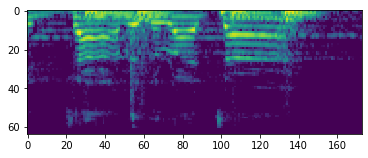

In [14]:
plt.imshow(mel_log(mel))

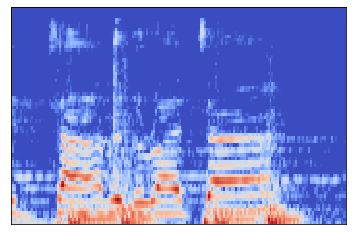

In [17]:
from librosa import display
lb.display.specshow(mel_log(mel))

The resulting Images are basically the same except that the [plt.imshow](https://matplotlib.org/3.1.3/api/_as_gen/matplotlib.pyplot.imshow.html) plots the image on a "upside down" y-axis (from 60 to 0).

In [66]:
#saving the images
count=0
# storing path and labels
data_images = []
# for genre in data:
for genre in labels:
    for sample in data[genre]:
        if not os.path.isfile("data/images/preprocessed/melspectogram_"+str(genre)+ "_" + str(count) +".png"):
            mel = lb.feature.melspectrogram(sample,sr=SR,n_fft=N_FFT,hop_length=HOP_LENGTH,n_mels=N_MELS)
            plt.imshow(mel_log(mel))
            plt.savefig("data/images/preprocessed/melspectogram_"+str(genre)+ "_" + str(count) +".png")
        data_images.append(("\\data\\images\\preprocessed\\melspectogram_"+str(genre)+ "_" + str(count) +".png", genre))
        count +=1

In [87]:
path = os.getcwd()

data_tensor = []
genre_list=[]
for file, genre in data_images:
    img=tf.io.read_file(path+file)
    img=tf.image.decode_png(img)
    data_tensor.append(img)
    genre_list.append(genre)

Create training and testing datasets

In [88]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data_tensor, genre_list, test_size=0.33)

['blues',
 'rock',
 'rock',
 'blues',
 'pop',
 'jazz',
 'classical',
 'blues',
 'rock',
 'blues',
 'jazz',
 'reggae',
 'classical',
 'disco',
 'blues',
 'classical',
 'metal',
 'metal',
 'pop',
 'hiphop',
 'jazz',
 'classical',
 'country',
 'rock',
 'reggae',
 'country',
 'reggae',
 'disco',
 'hiphop',
 'metal',
 'hiphop',
 'country',
 'rock',
 'reggae',
 'rock',
 'blues',
 'rock',
 'hiphop',
 'classical',
 'reggae',
 'disco',
 'metal',
 'jazz',
 'country',
 'disco',
 'country',
 'rock',
 'country',
 'classical',
 'jazz',
 'metal',
 'reggae',
 'pop',
 'metal',
 'disco',
 'disco',
 'jazz',
 'reggae',
 'rock',
 'country',
 'rock',
 'hiphop',
 'country',
 'pop',
 'disco',
 'metal',
 'country',
 'classical',
 'rock',
 'disco',
 'country',
 'hiphop',
 'classical',
 'rock',
 'country',
 'reggae',
 'classical',
 'rock',
 'classical',
 'blues',
 'jazz',
 'reggae',
 'reggae',
 'reggae',
 'jazz',
 'reggae',
 'country',
 'reggae',
 'jazz',
 'hiphop',
 'pop',
 'blues',
 'classical',
 'rock',
 'jaz

## Exploring the Dataset

# Preprocessing the Data


## Generating the Images

# The Convolutional Network

# Performance

# Results

# References

[1] http://cs229.stanford.edu/proj2018/report/21.pdf